## Import and Configure Everything We Need

In [1]:
%matplotlib inline
from collections import defaultdict as ddict
from copy import deepcopy as copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import SVG
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DSVG
from rdkit.Chem.rdmolops import SanitizeFlags
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Set the RDKit logging level to CRITICAL, because 
# lot of RDKit errors occur during the extraction of the 
# fragments. However, the corresponding molecules are 
# corrected in the further course.
RDLogger.logger().setLevel(RDLogger.CRITICAL)

# In many cases NaN
not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])

## Defining Helpful Functions

In [2]:
def calc_stats_str(pka1, pka2):
    """Calculates R² score and MAE for two iterables of floats or integers"""
    assert len(pka1) == len(pka2), "Both iterables must have the same length"
    return f'R²: {np.round(r2_score(pka1, pka2), 3)}\n' \
           f'MAE: {np.round(mean_absolute_error(pka1, pka2), 3)}'

def mol_to_svg(mol_, mol_size=(350,200), kekulize=True, highlight_atoms=(), highlight_atom_color=(0,1,0)):
    """Draws a molecule as SVG and optionally highlights atoms in the specified color"""
    mc = copy(mol_)
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except ValueError:
            pass
    if not mc.GetNumConformers():
        Chem.Compute2DCoords(mc)
    drawer = MolDraw2DSVG(*mol_size)
    drawer.DrawMolecule(mc, 
                        highlightAtoms=highlight_atoms, 
                        highlightAtomColors=dict(zip(highlight_atoms, [highlight_atom_color] * len(highlight_atoms))))
    drawer.FinishDrawing()
    return SVG(drawer.GetDrawingText())

def remove_aromatization(mol_):
    """Removes aromatization for every atom in a molecule"""
    for aa in mol_.GetAromaticAtoms():
        aa.SetIsAromatic(False)

def extract_env(mol_, atom_ix, radius):
    """Extract a fragment out of a molecule around the given atom index with the given radius"""
    bond_ix = Chem.FindAtomEnvironmentOfRadiusN(mol_, radius, atom_ix)
    if len(bond_ix) == 0:
        return None
    atom_ix_set = set()
    for bix in bond_ix:
        b = mol_.GetBondWithIdx(bix)
        atom_ix_set.add(b.GetBeginAtomIdx())
        atom_ix_set.add(b.GetEndAtomIdx())
    return Chem.MolFromSmiles(Chem.MolFragmentToSmiles(mol_, atom_ix_set, bond_ix), sanitize=False)

def get_atom_env_mol(mol_, atom_ix, radius):
    """Calls 'extract_env()' with the given parameters and try to solve occurring problems"""
    um = None
    r = radius
    # Try to extract the molecule. If the radius is higher than
    # maximum possible binding length in the given molecule, the
    # 'FindAtomEnvironmentOfRadiusN' returns None. Therefore
    # the radius is lowered until we get a mol object.
    while um is None and r > 0:
        um = extract_env(mol_, atom_ix, r)
        r -= 1
    if um is None:
        raise ValueError('No environment extractable')
        
    r = radius + 1
    not_sanitized = Chem.SanitizeMol(um, catchErrors=True)
    # Fragment have to be sanitized to calculate all descriptors
    # without errors or strange values
    while not_sanitized:
        # This happens if the extraction of the fragment breaks
        # an aromatic ring. After removing the aromatization
        # flags manually from all atoms sanitization is possible.
        # During the sanitization the aromatization flags are
        # corrected automatically again.
        if not_sanitized == SanitizeFlags.SANITIZE_KEKULIZE:
            remove_aromatization(um)
        # In this case the extraction broke something in a not
        # correctable way. Then a new fragment with a higher radius
        # have to be extracted.
        elif not_sanitized == SanitizeFlags.SANITIZE_PROPERTIES:
            um = extract_env(mol_, atom_ix, r)
            r += 1
        not_sanitized = Chem.SanitizeMol(um, catchErrors=True)
    return um

def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))

## Loading Precombined Dataset

Initial: 3939


,ID,pKa,pKa_CX,atom,ROMol
0,1402,3.79,1.73,2,
1,1265,7.46,9.36,6,

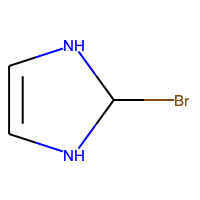
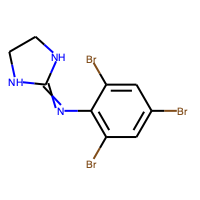

In [34]:
sdf_path = 'monoprotic_chembl_datawarrior.sdf'
all_df = PandasTools.LoadSDF(sdf_path).astype(dict(pKa=float, atom=int, pKa_CX=float), copy=False)
print(f'Initial: {len(all_df)}')
show(all_df.head(2))

## Show pK<sub>a</sub> Distribution

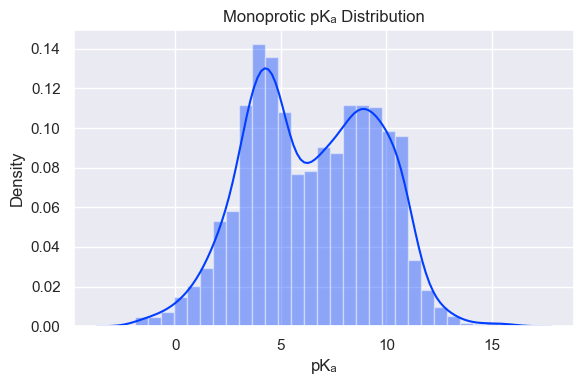

In [4]:
sns.set(palette='bright')
plt.figure(dpi=100)
sns.distplot(all_df.pKa)
plt.ylabel('Density')
plt.xlabel('pKₐ')
plt.title('Monoprotic pKₐ Distribution')
plt.tight_layout()
plt.show()

## Trying to Extract a Fragment Around The Protonation Group

In [5]:
test_ix = 2363
test_mol = copy(all_df.loc[test_ix, 'ROMol'])
pka_atom_ix = int(all_df.loc[test_ix, 'atom'])

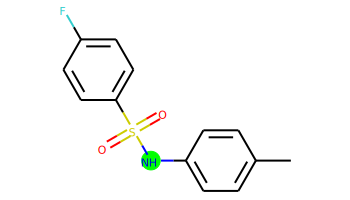

In [6]:
mol_to_svg(test_mol, highlight_atoms=[pka_atom_ix])

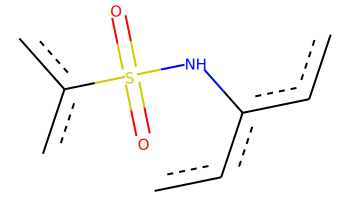

In [7]:
test_frag = get_atom_env_mol(test_mol, pka_atom_ix, 3)
mol_to_svg(test_frag)

## Prepare Fragments for All Molecules and Different Radii

In [8]:
min_radius = 1 # inclusive
max_radius = 6 # exclusive, is also the key for the complete molecule
radii = list(range(min_radius, max_radius))

,ID,pKa,pKa_CX,atom,ROMol,frag_R1,frag_R2,frag_R3,frag_R4,frag_R5
0,1402,3.79,1.73,2,,,,,,
1,1265,7.46,9.36,6,,,,,,
2,2261,0.65,0.64,11,,,,,,
3,2259,0.40,0.64,9,,,,,,
4,358,11.00,8.95,14,,,,,,

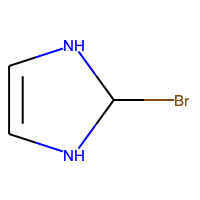
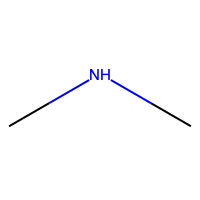
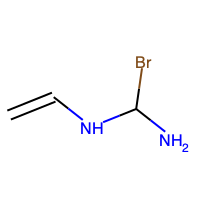
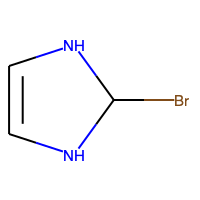
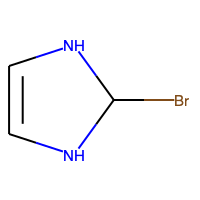
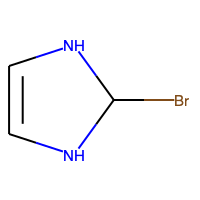
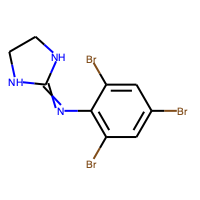
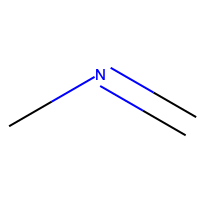
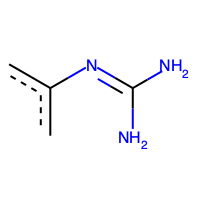
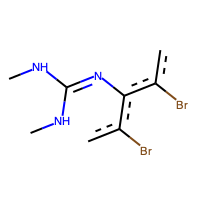
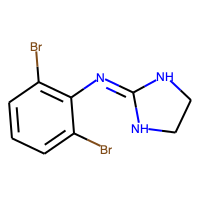
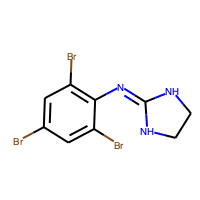
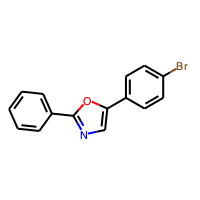
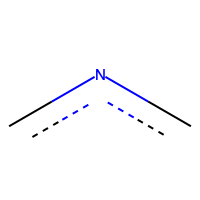
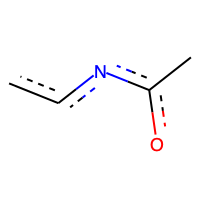
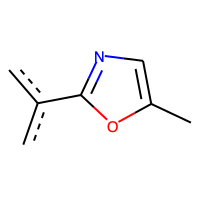
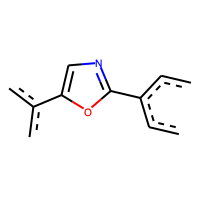
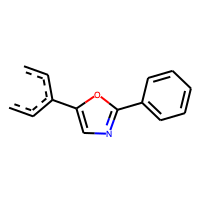
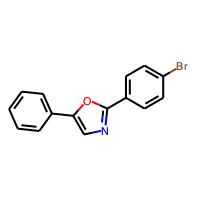
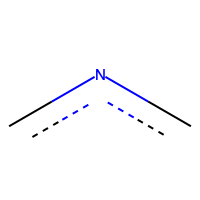
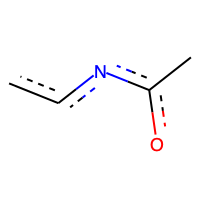
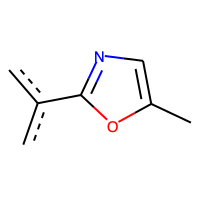
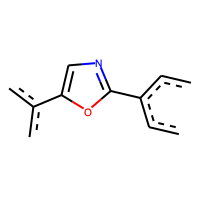
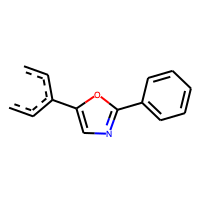
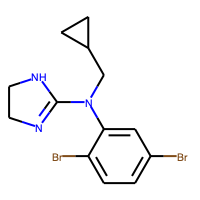
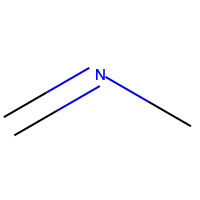
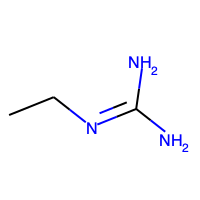
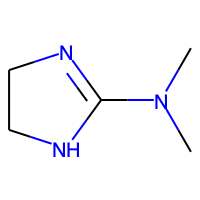
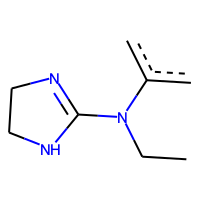
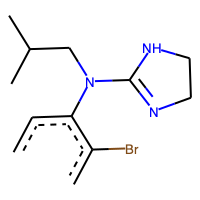

In [35]:
frags = ddict(list)

for _, row in all_df.iterrows():
    aix = int(row.atom)
    mol = row.ROMol
    for i in radii:
        frags[i].append(get_atom_env_mol(mol, aix, i))

for i in radii:
    all_df[f'frag_R{i}'] = frags[i]

show(all_df.head())

## Calculating Descriptors and Fingerprints for All Fragments and Different Radii

In [10]:
keys = radii + [max_radius]
descs = ddict(list)
for _, row in all_df.iterrows():
    for i in keys:
        mol = row.ROMol if i == max_radius else row[f'frag_R{i}']
        descs[i].append(desc_calc.CalcDescriptors(mol))

In [11]:
# Default 2048 bits for all fps
morgan0 = ddict(list)
morgan1 = ddict(list)
morgan2 = ddict(list)
morgan3 = ddict(list)
topol = ddict(list)
atpair = ddict(list)

for _, row in all_df.iterrows():
    for i in keys:
        mol = row.ROMol if i == max_radius else row[f'frag_R{i}']
        morgan0[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=0))
        morgan1[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=1))
        morgan2[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=2))
        morgan3[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=3))
        topol[i].append(Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol))
        atpair[i].append(Chem.GetHashedAtomPairFingerprintAsBitVect(mol))

## Prepare for Training

In [12]:
seed = 24
cv = 5
est_jobs = 12

all_x_data = dict(Descriptors=descs, Morgan0=morgan0, Morgan1=morgan1, Morgan2=morgan2, 
                  Morgan3=morgan3, Topological=topol, AtomPair=atpair)
y_data = all_df.pKa

kf = KFold(n_splits=cv, shuffle=True, random_state=seed)
spl = list(kf.split(descs[max_radius], y_data))

## 5-Fold Cross-Validate All Combinations of Radius and X_data

In [13]:
trees = 1000

In [14]:
all_scores = {}
for dsetname, dset in all_x_data.items():
    print(f'Random Forest - {dsetname}:')
    scores = {}
    for i in dset:
        est = RandomForestRegressor(n_estimators=trees, random_state=seed, n_jobs=est_jobs)
        score = cross_val_score(est, dset[i], y_data, cv=spl, error_score='raise')
        scores[i] = dict(r2=np.mean(score), r2_std=np.std(score))
        print(f'\tRadius {i if i != max_radius else "M"} - R²: '
              f'{np.round(scores[i]["r2"], 3)} ± {np.round(scores[i]["r2_std"], 3)}')
    all_scores[dsetname] = scores

Random Forest - Descriptors:
	Radius 1 - R²: 0.259 ± 0.041
	Radius 2 - R²: 0.608 ± 0.013
	Radius 3 - R²: 0.688 ± 0.029
	Radius 4 - R²: 0.728 ± 0.02
	Radius 5 - R²: 0.727 ± 0.021
	Radius M - R²: 0.72 ± 0.02
Random Forest - Morgan0:
	Radius 1 - R²: 0.249 ± 0.041
	Radius 2 - R²: 0.563 ± 0.021
	Radius 3 - R²: 0.583 ± 0.036
	Radius 4 - R²: 0.619 ± 0.037
	Radius 5 - R²: 0.574 ± 0.033
	Radius M - R²: 0.512 ± 0.039
Random Forest - Morgan1:
	Radius 1 - R²: 0.259 ± 0.038
	Radius 2 - R²: 0.598 ± 0.015
	Radius 3 - R²: 0.665 ± 0.03
	Radius 4 - R²: 0.709 ± 0.035
	Radius 5 - R²: 0.708 ± 0.03
	Radius M - R²: 0.701 ± 0.025
Random Forest - Morgan2:
	Radius 1 - R²: 0.26 ± 0.038
	Radius 2 - R²: 0.6 ± 0.015
	Radius 3 - R²: 0.658 ± 0.033
	Radius 4 - R²: 0.694 ± 0.034
	Radius 5 - R²: 0.681 ± 0.036
	Radius M - R²: 0.674 ± 0.029
Random Forest - Morgan3:
	Radius 1 - R²: 0.259 ± 0.038
	Radius 2 - R²: 0.599 ± 0.015
	Radius 3 - R²: 0.653 ± 0.035
	Radius 4 - R²: 0.689 ± 0.034
	Radius 5 - R²: 0.681 ± 0.032
	Radius M

In [36]:
# Sorry, I love one-liners...
score_df = pd.concat([pd.DataFrame([{'X_data': ix, 'Radius': col, 'R²': row[col]['r2']} for col in row.keys()]) for ix, row in pd.DataFrame(all_scores).transpose().iterrows()]).reset_index(drop=True)

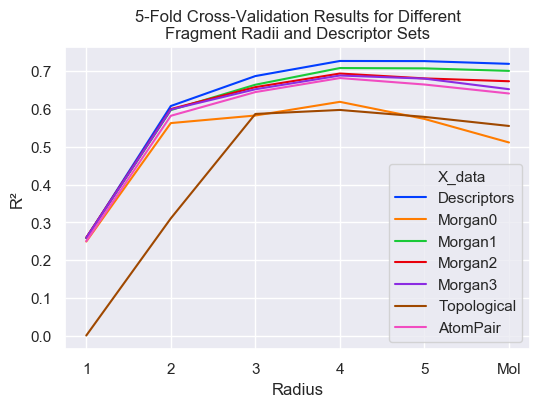

In [16]:
plt.figure(dpi=100)
plt.title('5-Fold Cross-Validation Results for Different\nFragment Radii and Descriptor Sets')
sns.lineplot(data=score_df, x='Radius', y='R²', hue='X_data')
plt.xticks([1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 'Mol'])
plt.show()

## Trying Random Forest, Support Vector Machine and Multilayer Perceptron
#### Using 
- Radius 4 Fragments
- Descriptors as X_data
- A 80/20 dataset split

In [17]:
rad = 4
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(descs[rad], y_data, test_size=test_size, random_state=seed)

### Random Forest

In [18]:
rf = RandomForestRegressor(n_estimators=trees, random_state=seed, n_jobs=est_jobs)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=12, oob_score=False, random_state=24, verbose=0,
                      warm_start=False)

In [19]:
rf_pred = rf.predict(x_test)
print(calc_stats_str(y_test, rf_pred))

R²: 0.742
MAE: 1.009


#### Feature Importance

In [20]:
feat_importance = pd.DataFrame(zip(desc_calc.descriptorNames, rf.feature_importances_), 
                               columns=['descriptor', 'importance']).sort_values('importance', ascending=False)
feat_importance.head(20)

,descriptor,importance
120,fr_COO2,0.086955
116,fr_Ar_N,0.072914
38,PEOE_VSA14,0.054033
61,SlogP_VSA2,0.047119
99,NumAromaticHeterocycles,0.045220
87,VSA_EState6,0.033289
1,MinEStateIndex,0.021516
84,VSA_EState3,0.020163
70,EState_VSA1,0.019133
114,fr_ArN,0.017944


### Support Vector Machine

In [21]:
svr_scaler = StandardScaler()
svr_scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
svr = SVR(gamma='auto')
svr.fit(svr_scaler.transform(x_train), y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
svr_pred = svr.predict(svr_scaler.transform(x_test))
print(calc_stats_str(y_test, svr_pred))

R²: 0.702
MAE: 1.113


### Multilayer Perceptron

In [24]:
mlp_scaler = StandardScaler()
mlp_scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
mlp = MLPRegressor(hidden_layer_sizes=(500, 500), random_state=seed, verbose=True)
mlp.fit(mlp_scaler.transform(x_train), y_train)

Iteration 1, loss = 7.93524155
Iteration 2, loss = 3.02530379
Iteration 3, loss = 2.02179922
Iteration 4, loss = 1.61341038
Iteration 5, loss = 1.41085550
Iteration 6, loss = 1.24390170
Iteration 7, loss = 1.12996965
Iteration 8, loss = 1.02152812
Iteration 9, loss = 0.93032075
Iteration 10, loss = 0.85597037
Iteration 11, loss = 0.77594077
Iteration 12, loss = 0.72222807
Iteration 13, loss = 0.66500266
Iteration 14, loss = 0.61951585
Iteration 15, loss = 0.58707511
Iteration 16, loss = 0.53793922
Iteration 17, loss = 0.51511384
Iteration 18, loss = 0.47253789
Iteration 19, loss = 0.45013537
Iteration 20, loss = 0.43971415
Iteration 21, loss = 0.41426743
Iteration 22, loss = 0.40178799
Iteration 23, loss = 0.41355584
Iteration 24, loss = 0.41012257
Iteration 25, loss = 0.37926373
Iteration 26, loss = 0.35014070
Iteration 27, loss = 0.33605176
Iteration 28, loss = 0.34436226
Iteration 29, loss = 0.33225023
Iteration 30, loss = 0.32870024
Iteration 31, loss = 0.34457193
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(500, 500), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=24, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [26]:
mlp_pred = mlp.predict(mlp_scaler.transform(x_test))
print(calc_stats_str(y_test, mlp_pred))

R²: 0.771
MAE: 0.934


## Plot Results

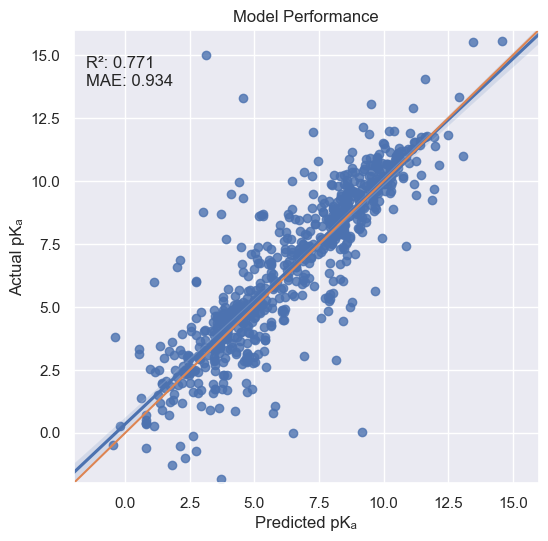

In [27]:
sns.set(color_codes=True)
plt.figure(figsize=(6, 6), dpi=100)
plt.title(f'Model Performance')
plt.xlim((-2, 16))
plt.ylim((-2, 16))
plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
p = sns.regplot(x=mlp_pred, y=y_test)
p.plot([-4, 18], [-4, 18])
p.text(-1.5, 13.8, calc_stats_str(y_test, mlp_pred))
plt.ylabel('Actual pKₐ')
plt.xlabel('Predicted pKₐ')
plt.show()

In [28]:
pka_cx = all_df.loc[y_test.index].pKa_CX

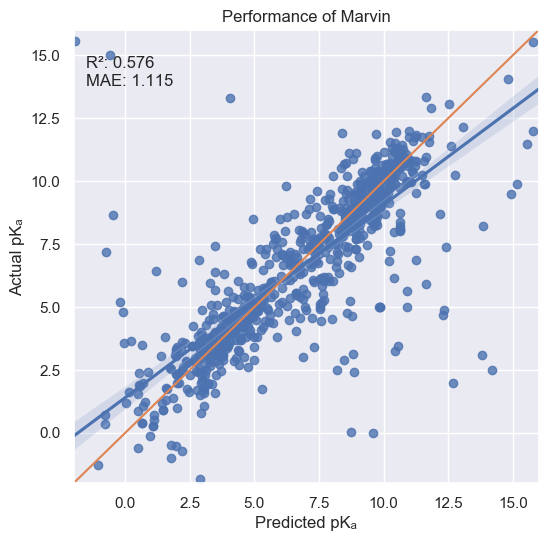

In [29]:
plt.figure(figsize=(6, 6), dpi=100)
plt.title(f'Performance of Marvin')
plt.xlim((-2, 16))
plt.ylim((-2, 16))
plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
p = sns.regplot(x=pka_cx, y=y_test)
p.plot([-4, 18], [-4, 18])
p.text(-1.5, 13.8, calc_stats_str(y_test, pka_cx))
plt.ylabel('Actual pKₐ')
plt.xlabel('Predicted pKₐ')
plt.show()

## Validate with External Dataset

In [30]:
# This dataset is not included
ext_dataset = PandasTools.LoadSDF('external_testset.sdf')
ext_frags = [get_atom_env_mol(row.ROMol, int(row.atom), rad) for _, row in ext_dataset.iterrows()]
ext_pka_cx = ext_dataset.pKa_CX.astype(float)
ext_x_data = mlp_scaler.transform([desc_calc.CalcDescriptors(mol) for mol in ext_frags])
ext_y_data = ext_dataset.pKa.astype(float)
len(ext_dataset)

93

In [31]:
ext_pred = mlp.predict(ext_x_data)

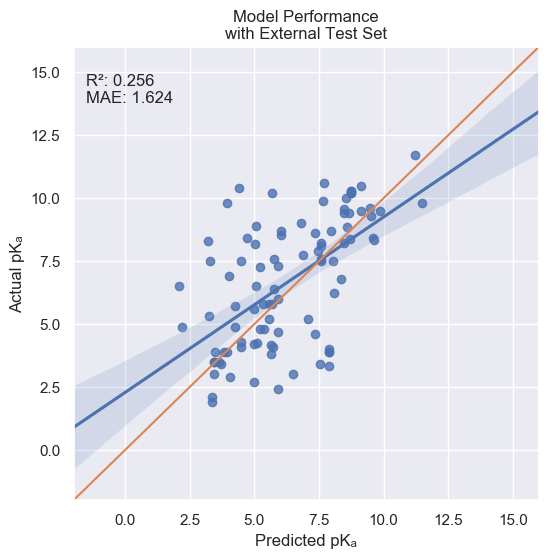

In [32]:
plt.figure(figsize=(6, 6), dpi=100)
plt.title(f'Model Performance\nwith External Test Set')
plt.xlim((-2, 16))
plt.ylim((-2, 16))
plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
p = sns.regplot(x=ext_pred, y=ext_y_data)
p.plot([-4, 18], [-4, 18])
p.text(-1.5, 13.8, calc_stats_str(ext_y_data, ext_pred))
plt.ylabel('Actual pKₐ')
plt.xlabel('Predicted pKₐ')
plt.show()

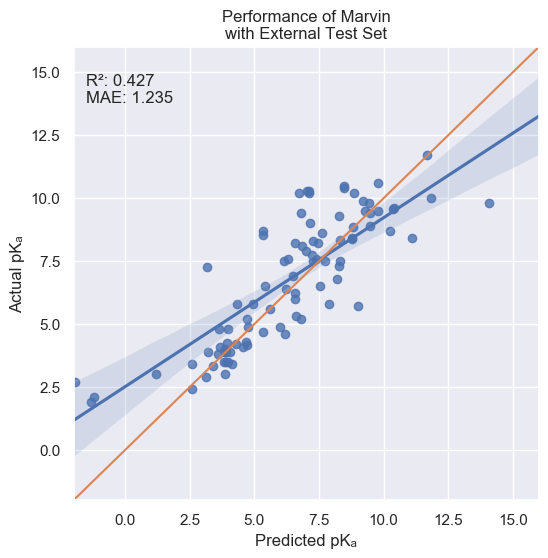

In [33]:
plt.figure(figsize=(6, 6), dpi=100)
plt.title(f'Performance of Marvin\nwith External Test Set')
plt.xlim((-2, 16))
plt.ylim((-2, 16))
plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
p = sns.regplot(x=ext_pka_cx, y=ext_y_data)
p.plot([-4, 18], [-4, 18])
p.text(-1.5, 13.8, calc_stats_str(ext_y_data, ext_pka_cx))
plt.ylabel('Actual pKₐ')
plt.xlabel('Predicted pKₐ')
plt.show()